In [157]:
import fermi.tipsh as tipsh
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.wcs.wcsapi import SlicedLowLevelWCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from astropy.visualization.wcsaxes.frame import EllipticalFrame
import pywt
import numpy
import math
import fermi.rl as rl
import os

os.system("taskset -p 0xff %d" % os.getpid())

0

pid 11842's current affinity mask: ff
pid 11842's new affinity mask: ff


In [130]:
data_file = get_pkg_data_filename('lat_ultracleanveto_front_zmax90_5-10gev_ccube.fits')
point_model_file = get_pkg_data_filename('5-10gev_binned_point_model_map.fits')
diffuse_model_file = get_pkg_data_filename('5-10gev_binned_diffuse_model_map.fits')
galactic_model_file = get_pkg_data_filename('5-10gev_binned_galactic_diffuse_model_map.fits')
isotropic_model_file = get_pkg_data_filename('5-10gev_binned_isotropic_diffuse_model_map.fits')

In [131]:
count_cube = fits.getdata(data_file, ext=0)
count_data = count_cube[0]
point_model = fits.getdata(point_model_file, ext=0)
diffuse_model = fits.getdata(diffuse_model_file, ext=0)
galactic_model = fits.getdata(galactic_model_file, ext=0)
isotropic_model = fits.getdata(isotropic_model_file, ext=0)

In [127]:
dnorm = sum(sum(diffuse_model))
d = diffuse_model/dnorm
pnorm = sum(sum(point_model))
p = point_model/pnorm
gnorm = sum(sum(galactic_model))
g = galactic_model/gnorm
inorm = sum(sum(isotropic_model))
iso = isotropic_model/inorm

In [133]:
z0 = [dnorm, pnorm, gnorm, inorm]
psfs = [d, p, g, iso]
zk = z0

In [165]:
zk = rl.rl1(psfs, zk, count_data)
[i / j for i,j in zip(zk, z0)]

[0.47203915051490386,
 0.9128761025994718,
 0.4203577356335772,
 0.47067455865423574]

In [161]:
#def fz(z):
#    return loss(psfs, z, count_data, d2_loss_map)
#zknm = minimize(fz, zk, method='Nelder-Mead')

In [166]:
im0 = rl.image_conv(zk, psfs)
total_model = im0

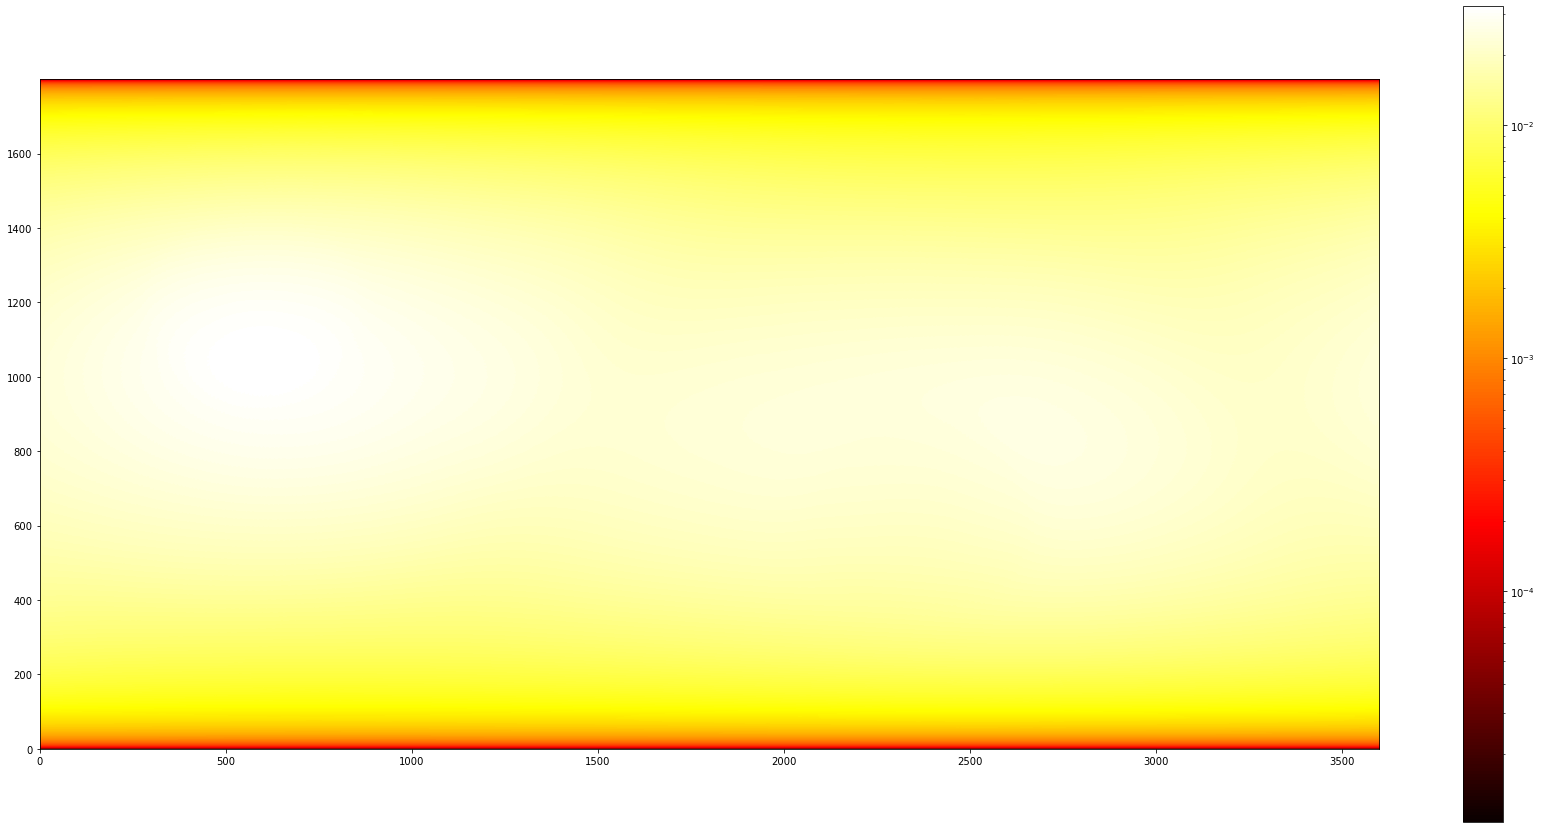

In [159]:
fig = plt.figure(figsize=(30, 15))
diff = plt.imshow(isotropic_model, cmap=plt.cm.hot, norm=colors.LogNorm(), origin='lower')
plt.colorbar(diff)
#imshow_mollweide(diffuse_model, plt.cm.hot, colors.LogNorm())

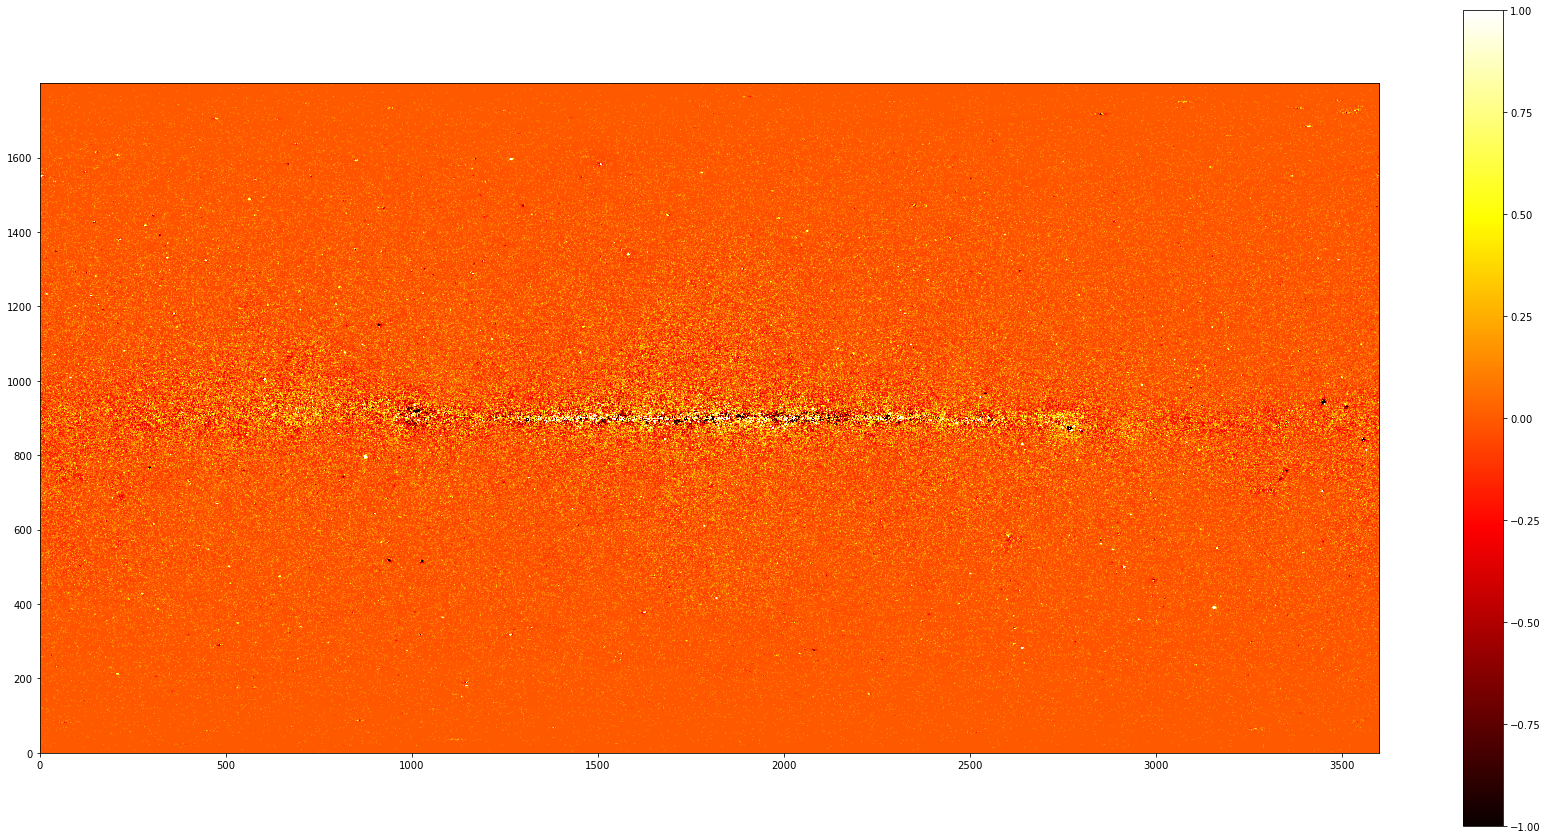

In [174]:
total_model = numpy.add(numpy.add(numpy.add(0.85*point_model, 1.0*diffuse_model), 0.85*galactic_model), 1.0*isotropic_model)
fig = plt.figure(figsize=(30, 15))
diff = plt.imshow(numpy.subtract(count_data, total_model), cmap=plt.cm.hot, norm=colors.Normalize(vmin=-1,vmax=1), origin='lower')
plt.colorbar(diff)

In [ ]:
def zero(n):
    return numpy.zeros((n,n), float)

def checkers(n, p):
    arr = numpy.zeros((n, 2*n), float) + 2
    for row in range(n):
        rq, rr = divmod(row, p)
        row_mult = 1 if rq % 2 == 0 else -1
        for col in range(2*n):
            cq, cr = divmod(col, p)
            col_mult = 1 if cq % 2 == 0 else -1
            arr[row,col] += row_mult*col_mult
    return arr

def delta(n, row, col):
    arr = numpy.zeros((n, 2*n), float) 
    arr[row, col] = 1
    return arr

def stripe(n, rows):
    arr = numpy.zeros((n, 2*n), float) 
    arr[rows, :] = 1
    return arr

In [31]:
#count_model = stripe(30, [13,14,15])*10 + 1
#data_model = 0.225*count_model #+ stripe(30, [13,14,15])*10 #+ 20*delta(30, 15, 15)
#count_data = poisson.rvs(data_model)
#a_model, hs_model, vs_model, ds_model = haar(count_model)
#a_data, hs_data, vs_data, ds_data = haar(count_data)

In [ ]:
a, hs, vs, ds = tipsh.haar_threshold_sphere(count_data, total_model, 0.001, fwer='uniform')

12 11 1 ******************************
alpha_j 0.001
sums
h threshold
small_left
small_right


In [153]:
count_rec = tipsh.inv_haar_sphere(a, hs, vs, ds)
print(sum(sum(count_data)), sum(sum(total_model)), sum(sum(count_rec)))

807712 807712.1345470804 807716.1333541992


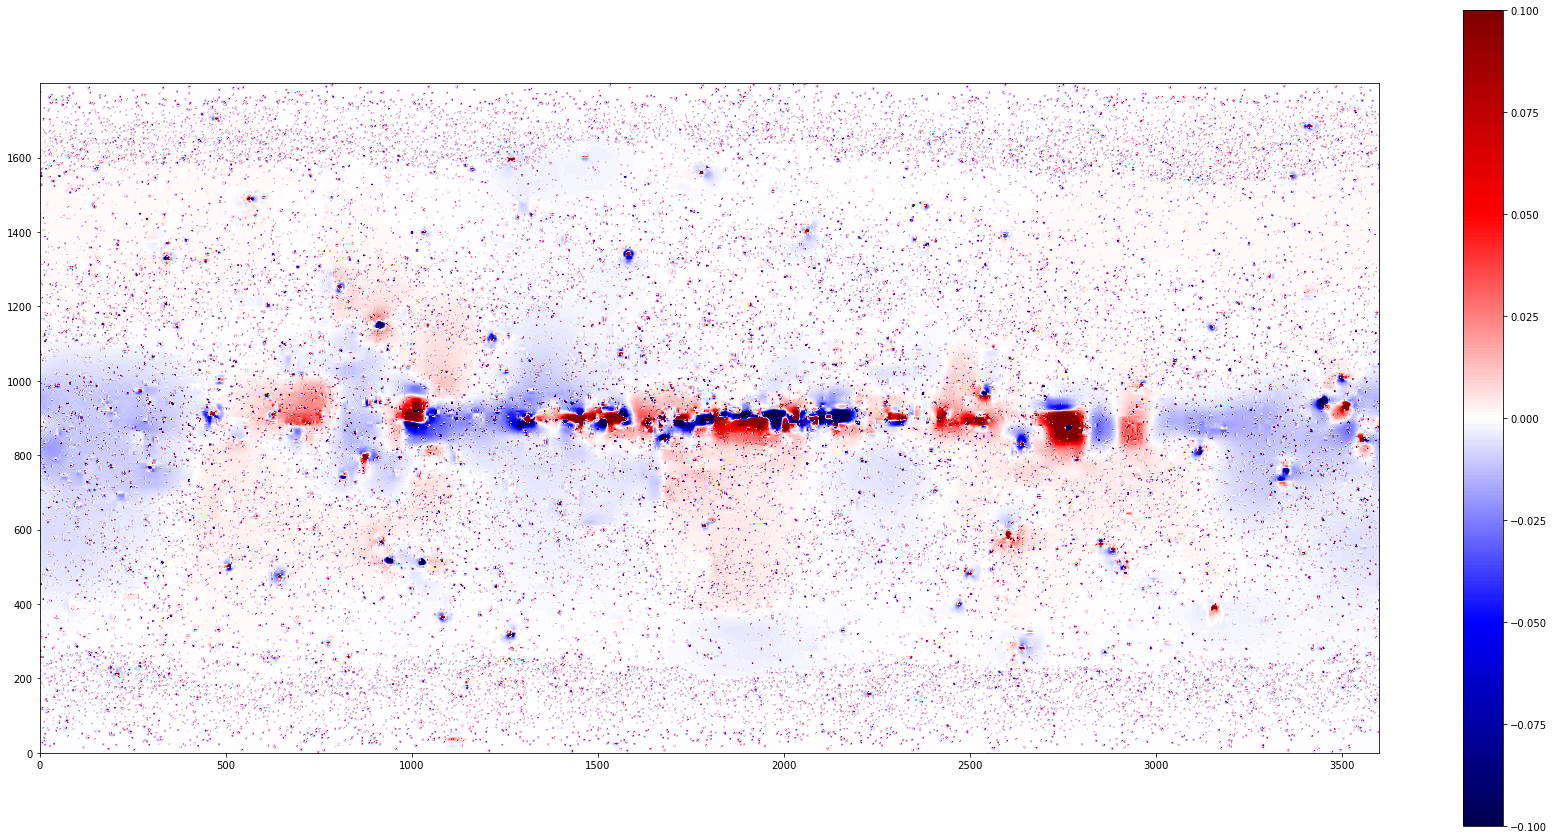

In [155]:
fig = plt.figure(figsize=(30, 15))
diff = plt.imshow(numpy.subtract(count_rec, total_model), cmap=plt.cm.seismic, norm=colors.Normalize(vmin=-0.1,vmax=0.1), origin='lower')
plt.colorbar(diff)

In [29]:
count_rec2_5 = count_rec

In [64]:
lon = numpy.arange(-180, 180, 0.1)
lat = numpy.arange(-90, 90, 0.1)
Lat, Lon = numpy.meshgrid(lon, lat)
levels = numpy.arange(-1, 5, 0.1)

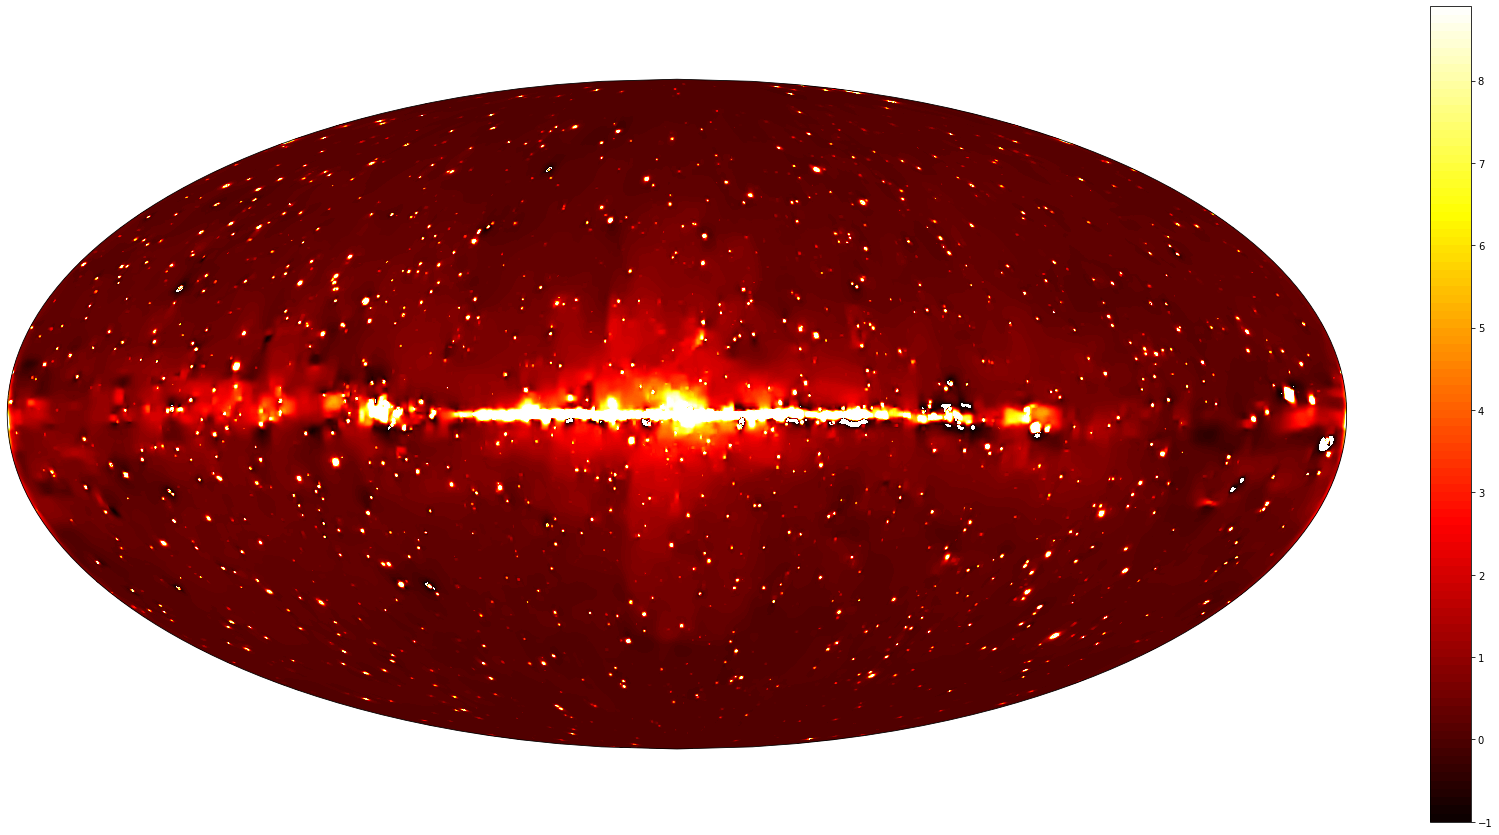

In [47]:
fig = plt.figure(figsize=(30, 15))
ax = plt.subplot(projection=ccrs.Mollweide())
foo = plt.contourf(Lat, Lon, numpy.subtract(count_rec, total_model), levels, cmap=plt.cm.hot, linewidths=0.3, transform=ccrs.PlateCarree())
plt.colorbar(foo)

In [398]:
numpy.logspace(-1,1)

array([ 0.1       ,  0.10985411,  0.12067926,  0.13257114,  0.14563485,
        0.15998587,  0.17575106,  0.19306977,  0.21209509,  0.23299518,
        0.25595479,  0.28117687,  0.30888436,  0.33932218,  0.37275937,
        0.40949151,  0.44984327,  0.49417134,  0.54286754,  0.59636233,
        0.65512856,  0.71968567,  0.79060432,  0.86851137,  0.95409548,
        1.04811313,  1.1513954 ,  1.26485522,  1.38949549,  1.52641797,
        1.67683294,  1.84206997,  2.02358965,  2.22299648,  2.44205309,
        2.6826958 ,  2.9470517 ,  3.23745754,  3.55648031,  3.90693994,
        4.29193426,  4.71486636,  5.17947468,  5.68986603,  6.25055193,
        6.86648845,  7.54312006,  8.28642773,  9.10298178, 10.        ])

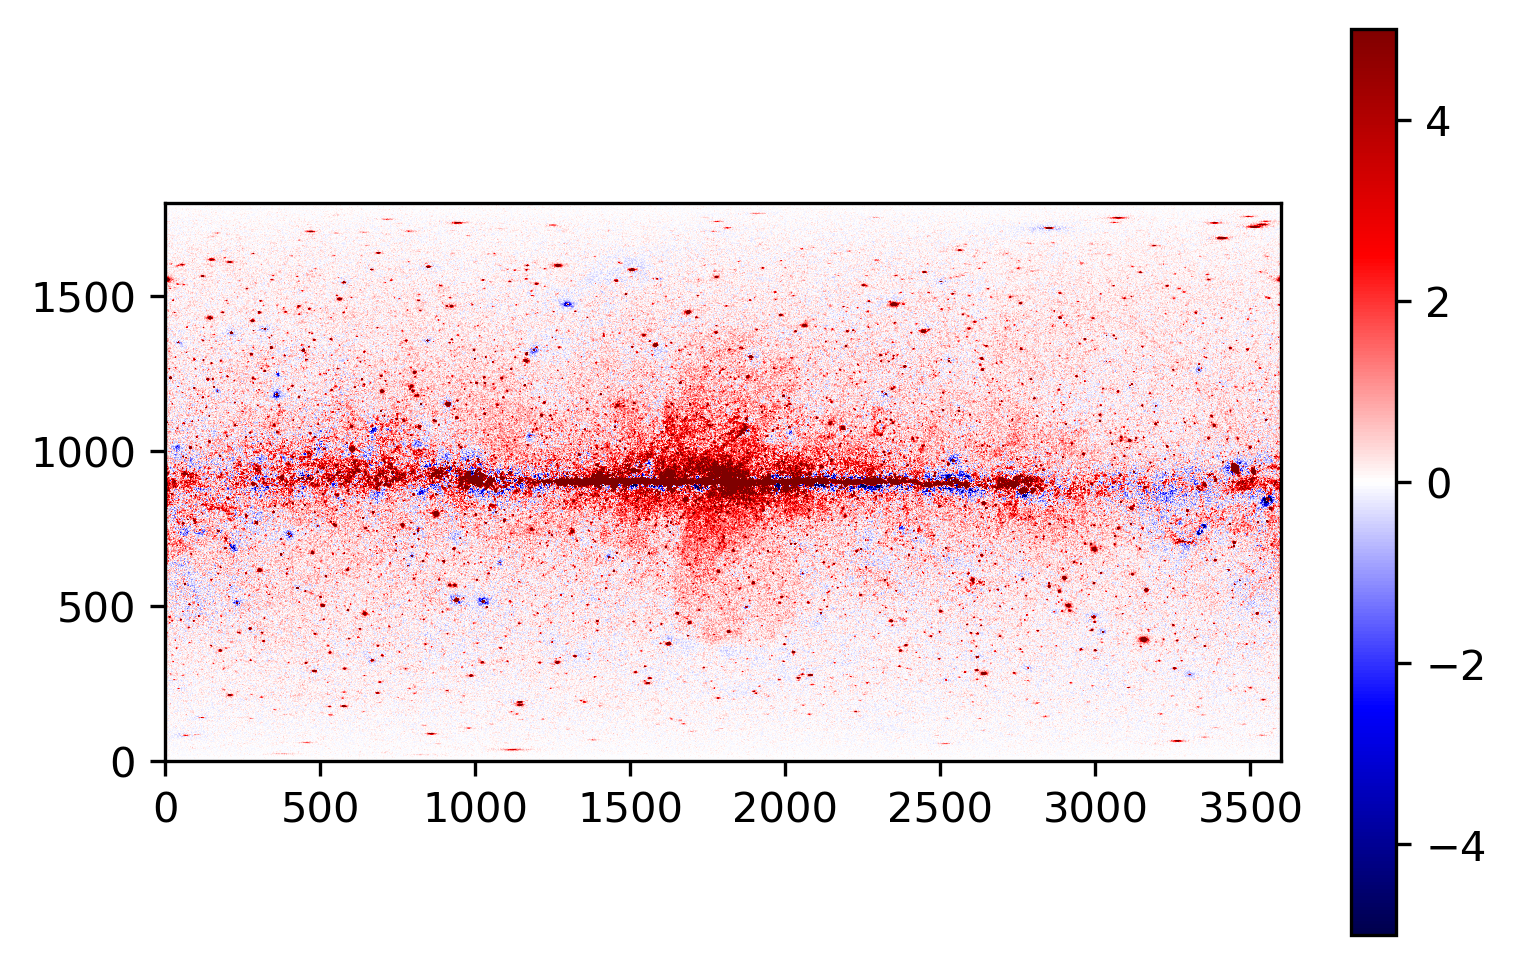

In [354]:
foo = plt.imshow(numpy.subtract(count_data, total_model), cmap=plt.cm.seismic, origin='lower', norm=colors.Normalize(vmin=-5,vmax=5))
plt.colorbar(foo)

In [21]:
import itertools
def inv_haar_level(j, a, hs, vs, ds):
    zs = numpy.zeros(a.shape)
    hsp = list(itertools.repeat(zs, len(hs)))
    vsp = list(itertools.repeat(zs, len(vs)))
    dsp = list(itertools.repeat(zs, len(ds)))
    ap = zs
    hsp[j] = hs[j]
    vsp[j] = vs[j]
    dsp[j] = ds[j]
    return tipsh.inv_haar_sphere(ap, hsp, vsp, dsp)

In [ ]:
rlev = inv_haar_level(3, a, hs, vs, ds)

(<Figure size 2160x1080 with 2 Axes>, <GeoAxesSubplot:>)

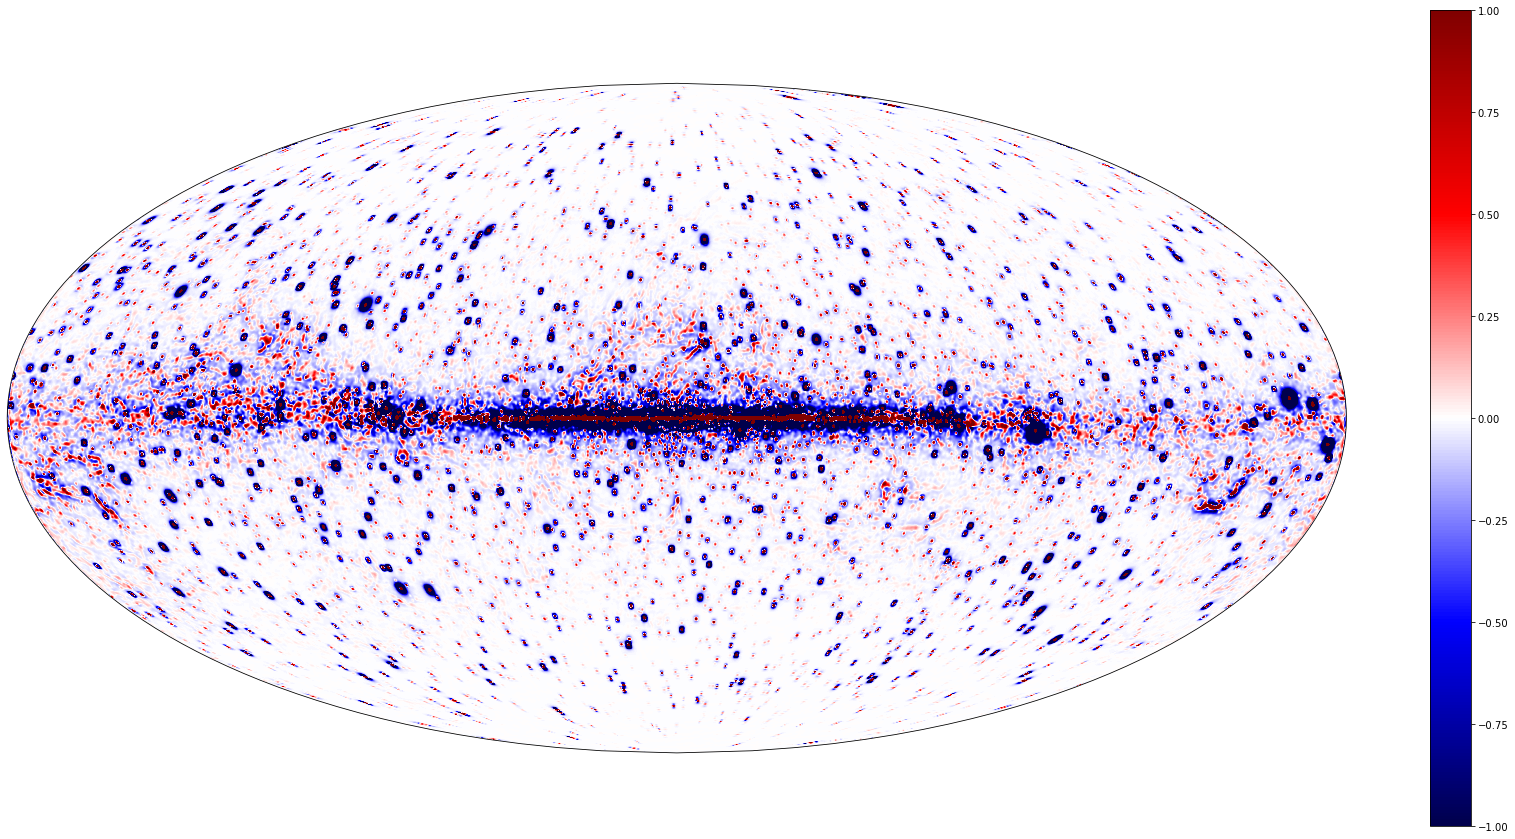

In [32]:
imshow_mollweide(rlev, plt.cm.seismic, colors.Normalize(vmin=-1,vmax=1))

In [24]:
fig.savefig("2022-01-01_1_500_GeV_uniform_001.png")

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



In [23]:
numpy.savez_compressed("2022-01-01_uniform_001.npz", a=a,hs=hs,vs=vs,ds=ds)

In [40]:
numpy.savez_compressed("count_rec_2022-01-01_uniform_001.npz", count_rec=count_rec)

In [7]:
tmp = numpy.load("2022-01-01_uniform_000001.npz")
a = tmp['a']
hs = tmp['hs']
vs = tmp['vs']
ds = tmp['ds']

In [18]:
count_rec = numpy.load("count_rec_2022-01-01_uniform_000001.npz")['count_rec']

In [30]:
del a, hs, vs, ds

In [62]:
print(sum(sum(count_data)))
print(sum(sum(a)))
print(sum(sum(a2)))
print(sum(sum(a_rec)))
print(sum(sum(count_rec)))
sum(sum(a))/sum(sum(count_data))

32568200
65136400.0
130272792.0
65136396.0
32568200.0


2.0

In [418]:
#foo = plt.imshow(roll_sphere(dx, -1, 0), origin='lower')
#plt.colorbar(foo)
roll_sphere(roll_sphere(im, 1, 0), -1, 0)

1 0 1 8 0
2 0 2 7 0
3 0 3 6 0
4 0 4 5 0
5 0 5 4 0
6 0 6 3 0
7 0 7 2 0
8 0 8 1 0
9 0 9 0 0
10 1 0 9 5
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
9 0 9 0 -4
0 0 0 9 0
1 0 1 8 0
2 0 2 7 0
3 0 3 6 0
4 0 4 5 0
5 0 5 4 0
6 0 6 3 0
7 0 7 2 0
8 0 8 1 0


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [188]:
a, h, v, d = haar_j(12, 11, count_data)

In [192]:
a10, _, _, _ = haar_j(12, 10, a)
a9, _, _, _ = haar_j(12, 9, a10)
a8, _, _, _ = haar_j(12, 8, a9)
a7, _, _, _ = haar_j(12, 7, a8)
a6, _, _, _ = haar_j(12, 6, a7)
a5, _, _, _ = haar_j(12, 5, a6)
a4, _, _, _ = haar_j(12, 4, a5)
a3, _, _, _ = haar_j(12, 3, a4)
a2, _, _, _ = haar_j(12, 2, a3)
a1, _, _, _ = haar_j(12, 1, a2)

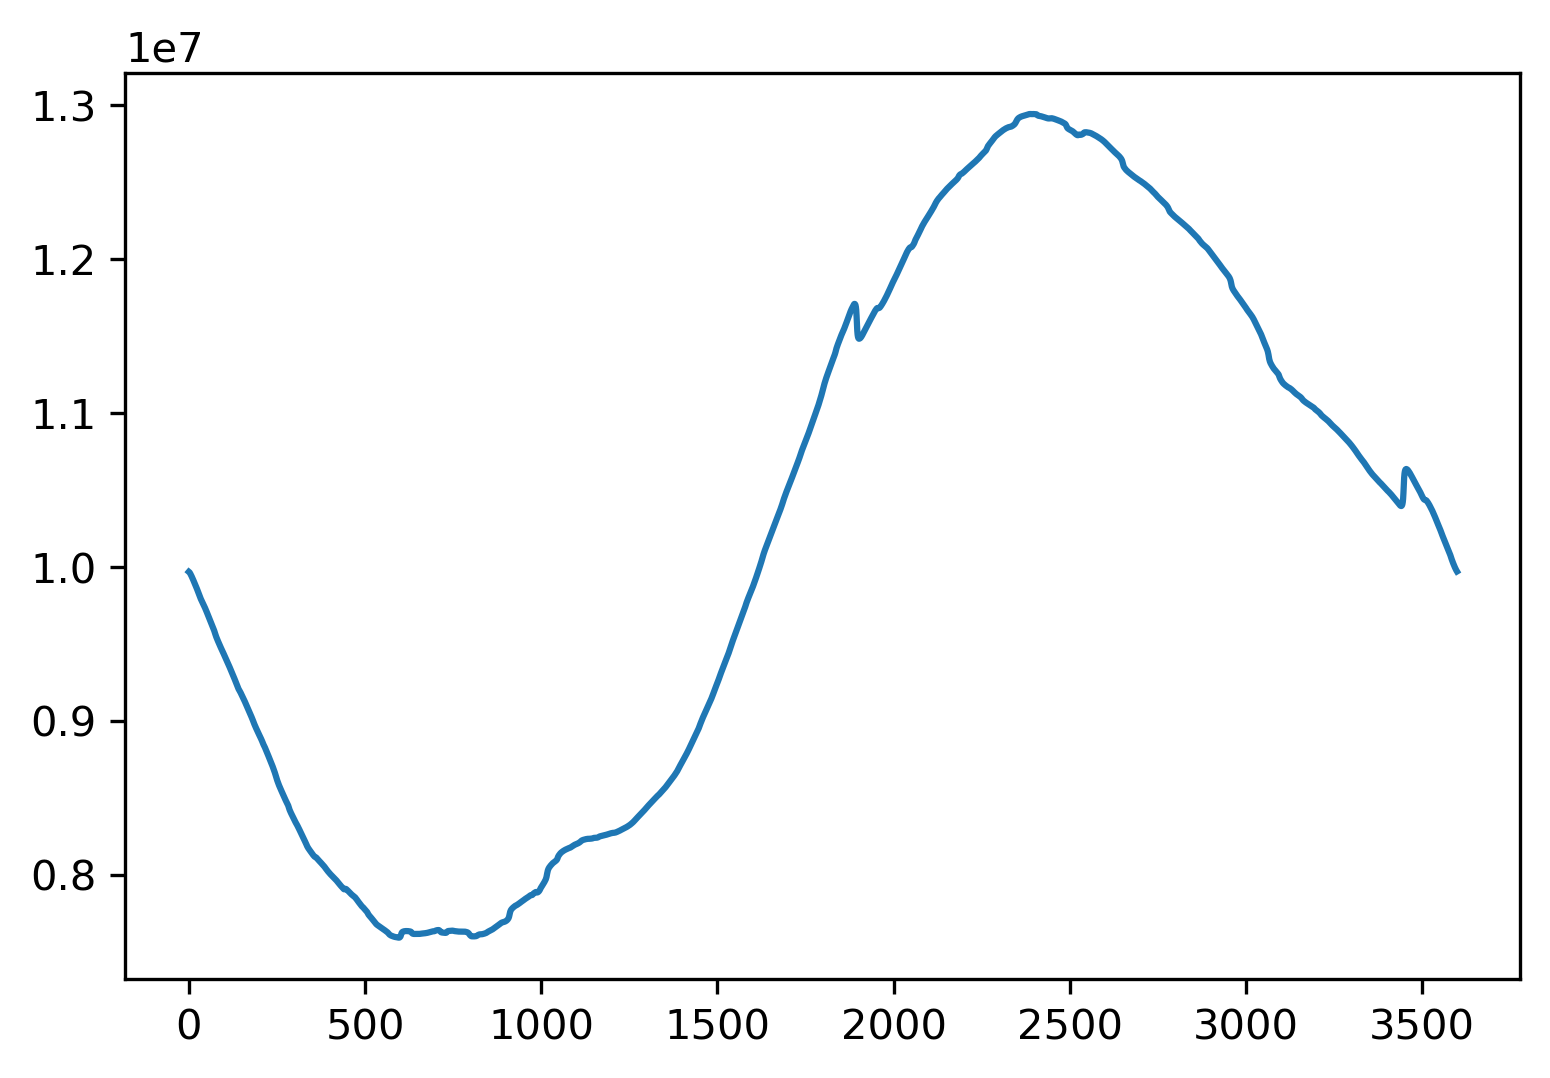

In [194]:
plt.plot(a1[900, :])

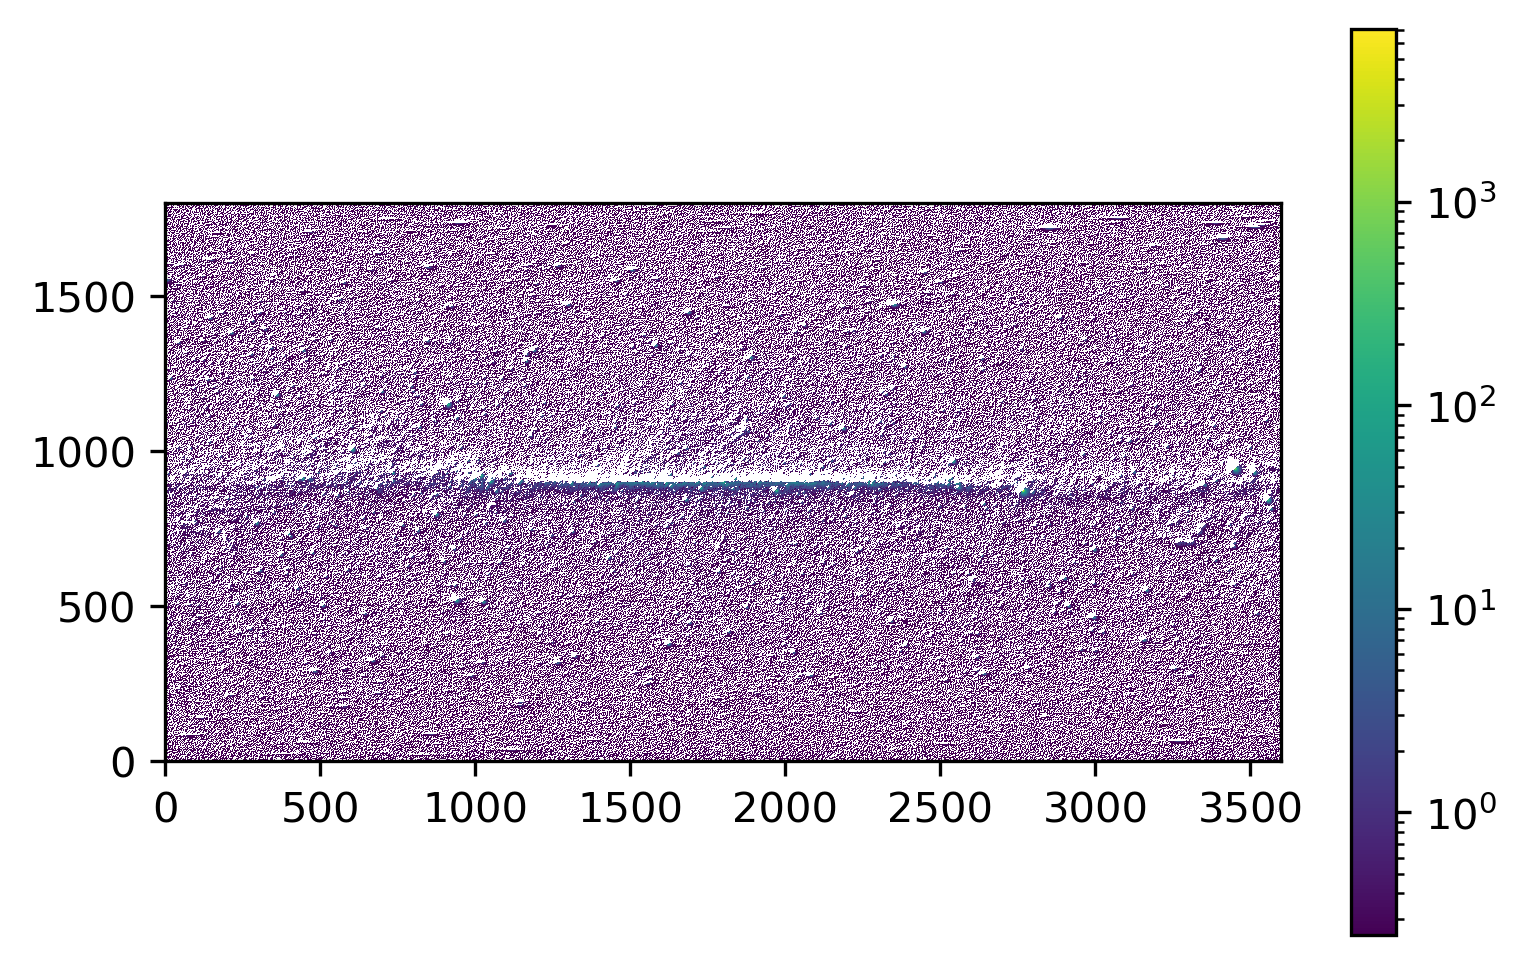

In [215]:
diff = plt.imshow(numpy.subtract(a / 4, count_data), origin='lower', cmap=plt.cm.viridis, norm=colors.LogNorm())
plt.colorbar(diff)

In [109]:
2**12

4096

In [16]:
ax.set_xlim(-180,180)

(-180.0, 180.0)

In [17]:
overlay = ax.get_coords_overlay('fk5')

In [18]:
overlay.grid(color='black', ls='dotted')